In [15]:
import xarray as xr
ds = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xch4                     (time, lat, lon) float32 ...
    xch4_nobs                (time, lat, lon) float64 ...
    xch4_stderr              (time, lat, lon) float32 ...
    xch4_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_ch4_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2021-02-05T09:48:47Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.3
    title:                  C3S XCH4 v4.3
    tracking_id:            892d184a-7b35-4bba-836a-94b9cfeb360e
    variable_id:            xch4
    variant_info:           Best Estimate
    variant_label:          BE

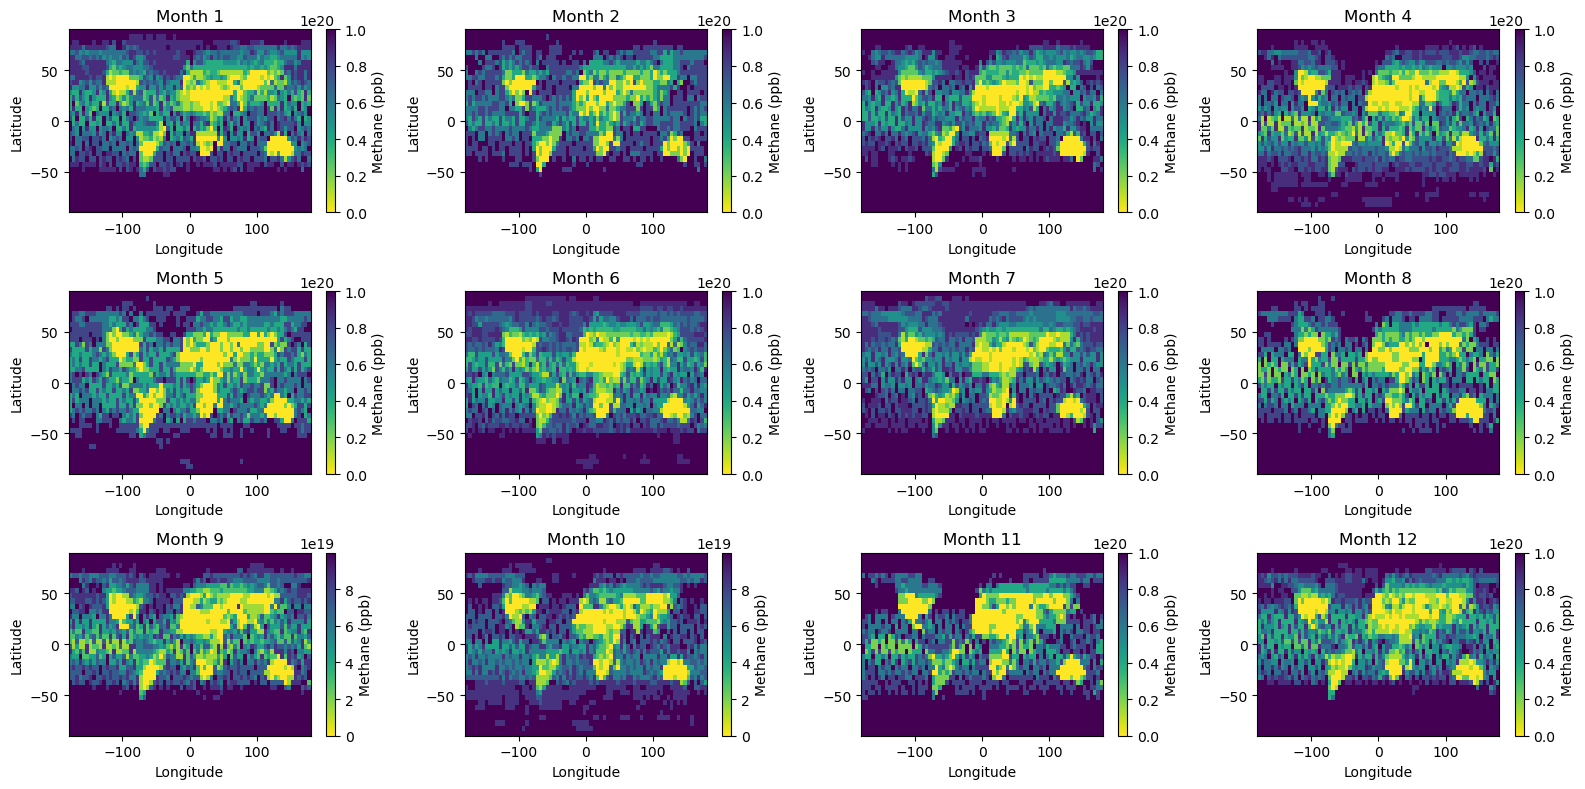

In [113]:
#1.1
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
ds = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")

#1.1
#加载所需数据（[:]：这是Python中用于切片的语法，表示选择变量的全部数据。）
time = ds.variables['time'][:]
lat = ds.variables['lat'][:]
lon = ds.variables['lon'][:]
methane = ds.variables['xch4'][:] 

#定义一个函数用于计算甲烷平均值
def calculate_monthly_climatology_xarray(methane, time):
    ds = xr.Dataset({'methane': (('time', 'lat', 'lon'), methane)}, coords={'time': time, 'lat': lat, 'lon': lon})
    monthly_climatology = ds.groupby('time.month').mean()
    return monthly_climatology.to_array().values

#绘图
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for month in range(12):
    #索引操作，决定对应月份的图在哪一行哪一列（month // 4：这是一个整数除法操作，它将 month 变量的值除以 4，并返回商的整数部分。month % 4：这是一个取模操作，它计算 month 变量的值除以 4 后的余数。）
    ax = axes[month // 4, month % 4]
    c = ax.pcolormesh(lon, lat, monthly_climatology[month, :, :], cmap='viridis_r', shading='auto')
    fig.colorbar(c, ax=ax, label='Methane (ppb)')
    ax.set_title(f'Month {month+1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

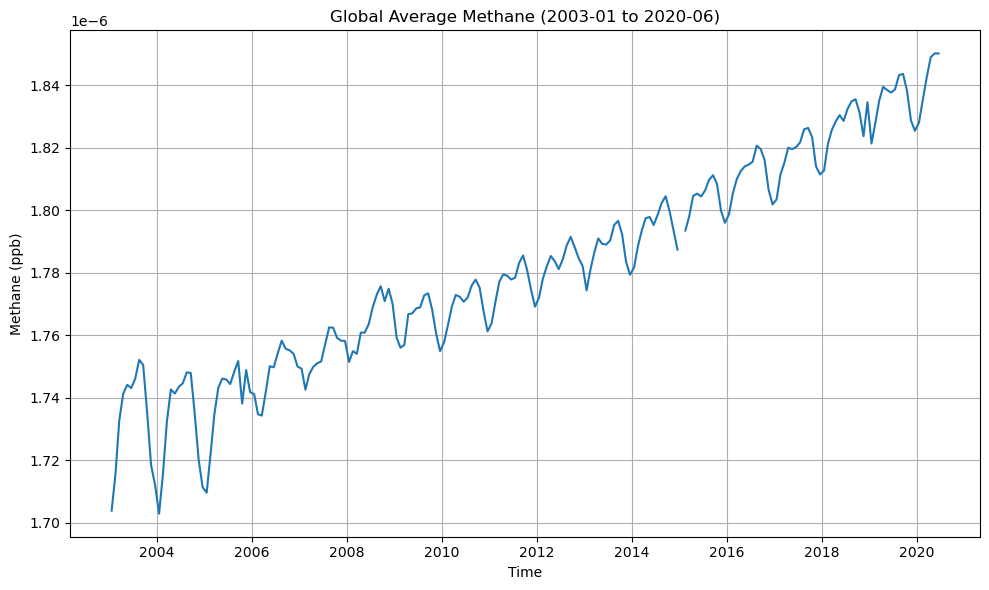

In [117]:
#1.2
#为了计算全球平均甲烷浓度，需要对空间维度（纬度和经度）进行平均，以得到每个时间点的全球平均值。
da = xr.DataArray(methane, dims=['time', 'lat', 'lon'])
global_avg_methane = da.mean(dim=['lat', 'lon']).values

#绘图
plt.figure(figsize=(10, 6))
plt.plot(time, global_avg_methane, label='Global Average Methane')
plt.xlabel('Time')
plt.ylabel('Methane (ppb)')
plt.title('Global Average Methane (2003-01 to 2020-06)')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1520\854123124.py:15: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  methane = ds.variables['xch4'][:]


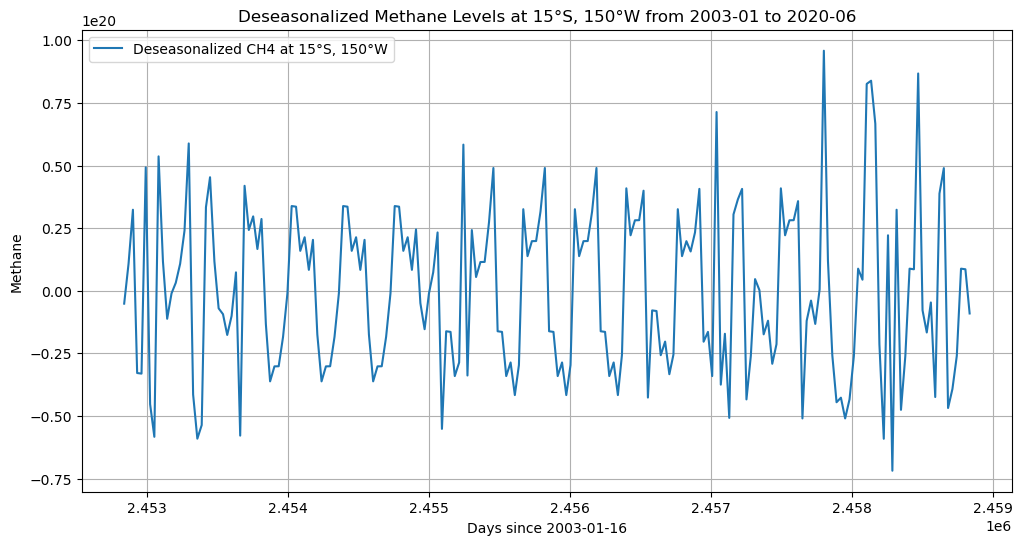

In [119]:
#1.3
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#在tsa模块中的seasonal子模块中调用一个函数seasonal_decompose，用于对时间进行季节性的分解(I got inspired by reading AI)
from statsmodels.tsa.seasonal import seasonal_decompose

# 读取文件
filename = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'
ds = nc.Dataset(filename)
#从文件中提取需要的信息
time = ds.variables['time'][:]
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
methane = ds.variables['xch4'][:]
#找距离网格点[15°S，150°W]最近的索引
#lat - - 15表示lat数组中每个值与15的差值；np.abs表示对这个差值取绝对值；np.argmin表示在这一串绝对值中取最小值，便找出了距离最近的网格点
lat_idx = np.argmin(np.abs(lat - - 15))
lon_idx = np.argmin(np.abs(lon - - 150))
#整理出在这个位置上的甲烷时间序列、
methane_series = methane[:, lat_idx, lon_idx]
#将时间转换为日期
time_dates = nc.num2date(time,ds.variables['time'].units)
# 将日期转换为matplotlib可以处理的格式（例如，从第一个日期开始的天数）
time_days = np.array([date.toordinal() for date in time_dates], dtype=float)

# 进行季节性分解
result = seasonal_decompose(methane_series, model='additive', period=12)

# 提取趋势和季节性分量
trend = result.trend
seasonal = result.seasonal

# 计算去季节性甲烷水平
deseasonalized_methane = result.resid

# 绘制去季节性甲烷水平的时间序列图
plt.figure(figsize=(12, 6))
plt.plot(time_days, deseasonalized_methane, label='Deseasonalized CH4 at 15°S, 150°W')
plt.xlabel('Days since ' + time_dates[0].strftime('%Y-%m-%d'))  # 使用strftime格式化日期
plt.ylabel('Methane')
plt.title('Deseasonalized Methane Levels at 15°S, 150°W from 2003-01 to 2020-06')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
#2
import xarray as xr
ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [72]:
#2.1
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# 加载netCDF文件
ds = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')

# 选择尼诺3.4区域的经纬度范围
nino34_lat = slice(-5, 5)
nino34_lon = slice(10, 60)  # 注意：这里的经度范围需要转换为0-360度，所以使用170W到120W

# 选择SST数据和指定的经纬度范围
sst = ds['sst'].sel(lat=nino34_lat, lon=nino34_lon)

# 计算月度气候平均值
monthly_climatology = sst.groupby('time.month').mean('time').mean([ 'lat', 'lon'])

monthly_climatology_array = monthly_climatology.values

# 计算所有年份的12个月的平均值
annual_monthly_mean = sst.groupby('time.month').mean([ 'lat', 'lon'])

annual_monthly_mean_array = annual_monthly_mean.values

# 将数组分成12个一组
reshaped_array = annual_monthly_mean_array.reshape(-1, 12)

monthly_climatology_reshaped = monthly_climatology_array.reshape(1, 12)

anomalies = reshaped_array - monthly_climatology_reshaped

# 打印结果
print(anomalies)

# 打印结果
print(reshaped_array)

# 打印结果
print(annual_monthly_mean)

# 打印结果
print(monthly_climatology)


import numpy as np


[[-4.47828293e-01 -3.80443573e-01 -7.21244812e-02 -2.73830414e-01
  -4.96706009e-01 -5.99813461e-01 -2.51220703e-01 -4.74803925e-01
  -3.21594238e-01 -4.12000656e-01 -7.12636948e-01 -2.39301682e-01]
 [ 1.27021790e-01  2.34699249e-02  2.28176117e-02  7.21836090e-02
   4.80823517e-02  1.76393509e-01  3.48745346e-01  1.74882889e-01
  -8.44955444e-04  1.37729645e-01 -6.37302399e-02 -9.93747711e-02]
 [-5.85174561e-02  1.76239014e-02  1.21225357e-01 -1.00368500e-01
  -2.43125916e-01 -3.12484741e-01 -1.48675919e-01  1.34544373e-02
  -6.19468689e-02  1.06510162e-01  9.10987854e-02  6.45713806e-02]
 [ 4.12368774e-02 -1.90063477e-01 -2.69897461e-01 -2.56299973e-01
  -3.91763687e-01 -2.00052261e-01 -5.75733185e-02 -6.55326843e-02
  -3.51755142e-01 -1.47699356e-01  1.57840729e-01  4.65698242e-02]
 [ 2.29038239e-01  2.25782394e-01  4.08859253e-02  9.32998657e-02
  -4.61793900e-01 -6.80278778e-01 -8.82251740e-01 -8.04513931e-01
  -8.85572433e-01 -8.27281952e-01 -7.01074600e-01 -6.23962402e-01]
 [-7.

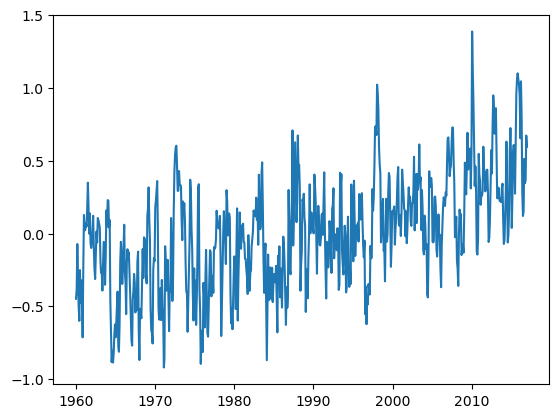

In [30]:
#2.2（Wuxy explained to me what is asked in problem set 2）
plt.plot(sst.time, anomalies.flatten())

In [82]:
#3
import os
import pandas as pd
data_dir = r"C:\Users\Lenovo\Desktop\output_file"

# xr.open_dataset(os.path.join(data_dir, file), engine="netcdf4")
data_range = pd.date_range(start='2015-01-01', end='2022-03-01', freq='ME').strftime("%Y%m")
for i in range(len(data_range)):
    data = data_range[i]
    file = "oco2_GEOS_L3CO2_month_%s_B10206Ar.nc4"%(data)
    file_ds = xr.open_dataset(os.path.join(data_dir, file), engine="netcdf4")
    print(file_ds)

<xarray.Dataset>
Dimensions:   (time: 1, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 2015-01-16T12:00:00
Data variables:
    XCO2      (time, lat, lon) float64 ...
    XCO2PREC  (time, lat, lon) float64 ...
Attributes: (12/25)
    RangeBeginningDate:             2015-01-01
    RangeBeginningTime:             00:00:00.000000
    RangeEndingDate:                2015-01-01
    RangeEndingTime:                23:59:99.999999
    SpatialCoverage:                global
    SouthBoundingCoordinate:        -90.0
    ...                             ...
    ProductionDateTime:             2022-03-15T11:56:04Z
    History:                        Original file generated: Tue Mar 15 11:56...
    ShortName:                      OCO2_GEOS_L3CO2_MONTH_10r
    LongName:                       OCO-2 GEOS Level 3 monthly, 0.5x0.6

In [100]:
file_ds

<xarray.Dataset>
Dimensions:   (time: 1, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 2022-02-15
Data variables:
    XCO2      (time, lat, lon) float64 ...
    XCO2PREC  (time, lat, lon) float64 ...
Attributes: (12/25)
    RangeBeginningDate:             2022-02-01
    RangeBeginningTime:             00:00:00.000000
    RangeEndingDate:                2022-02-01
    RangeEndingTime:                23:59:99.999999
    SpatialCoverage:                global
    SouthBoundingCoordinate:        -90.0
    ...                             ...
    ProductionDateTime:             2022-06-29T07:50:51Z
    History:                        Original file generated: Wed Jun 29 07:50...
    ShortName:                      OCO2_GEOS_L3CO2_MONTH_10r
    LongName:                       OCO-2 GEOS Level 3 monthly, 0.5x0.625 ass...
    Title:                          OCO-2 GEOS Level 3 monthly, 0.5x0.625 ass...
    IdentifierProductDOI:           10.5067/BGFIODET3HZ8

In [98]:
ds = xr.open_dataset('output_file.nc4')
ds

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 576, time: 86)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 2015-02-15 ... 2022-02-15
Data variables:
    XCO2     (time, lat, lon) float64 ...

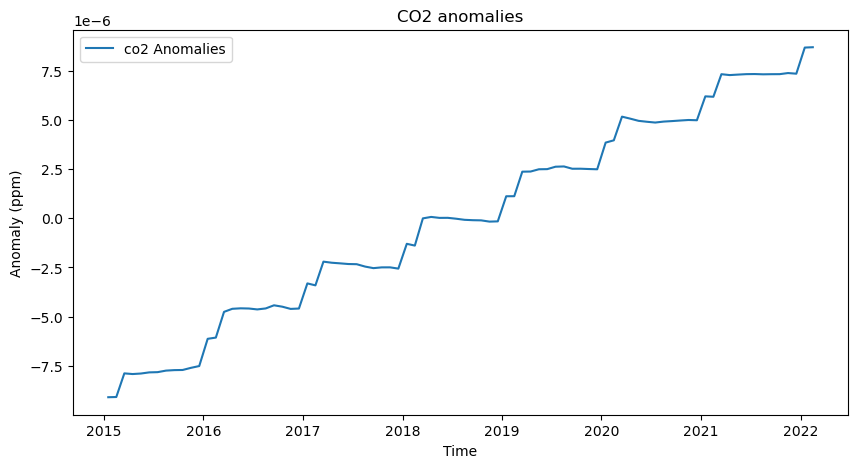

In [154]:
#3.1
#选择XCO2区域
xco2 = ds.XCO2.sel(lat=slice(-90, 90), lon=slice(-180, 179.4))
#将原始数据的空间进行平均
spatial_average = xco2.mean(dim=['lat', 'lon'])
#算月平均温度
monthly_avg = spatial_average.groupby('time.month').mean('time')
#计算异常值
anomalies = spatial_average.groupby('time.month') - monthly_avg

#绘图-时间序列图
plt.figure(figsize=(10, 5))
plt.plot(anomalies.time,anomalies, label='co2 Anomalies')
plt.title('CO2 anomalies')
plt.xlabel('Time')
plt.ylabel('Anomaly (ppm)')
plt.legend()
plt.show()

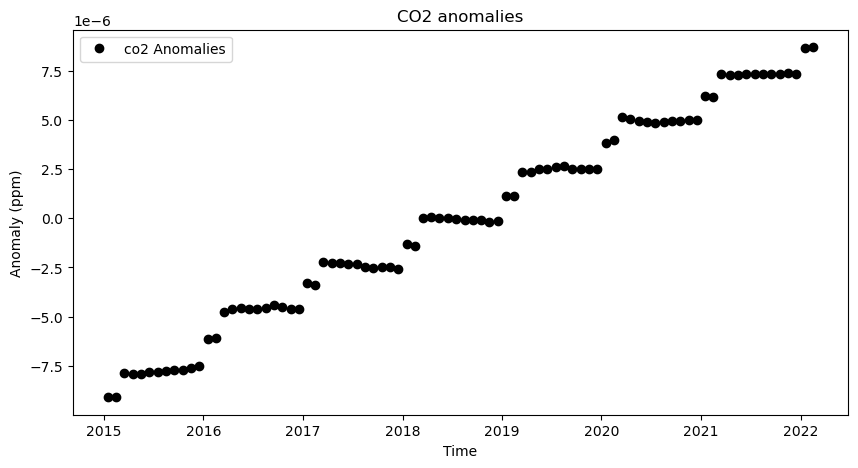

In [152]:
#3.2——1散点图
plt.figure(figsize=(10, 5))
plt.plot(anomalies.time, anomalies, 'ko', label='co2 Anomalies')
plt.title('CO2 anomalies')
plt.xlabel('Time')
plt.ylabel('Anomaly (ppm)')
plt.legend()
plt.show()

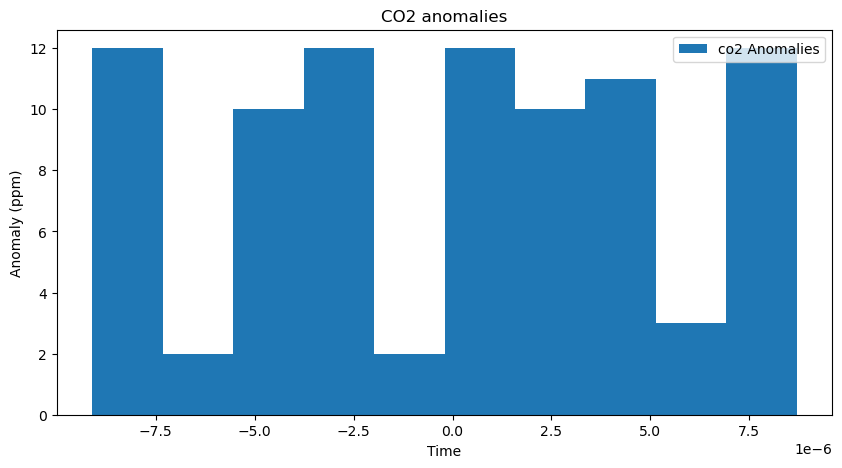

In [144]:
#3.2——2直方图
plt.figure(figsize=(10, 5))
plt.hist(anomalies, label='co2 Anomalies')
plt.title('CO2 anomalies')
plt.xlabel('Time')
plt.ylabel('Anomaly (ppm)')
plt.legend()
plt.show()

<Figure size 1000x500 with 0 Axes>

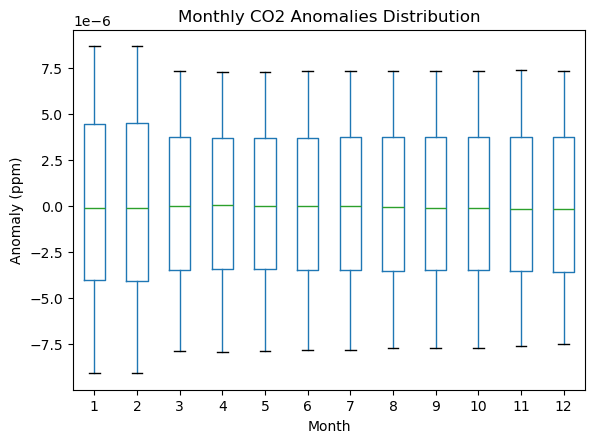

In [160]:
#3.2——3箱线图
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
ds = xr.open_dataset("output_file.nc4", engine="netcdf4")

xco2 = ds.XCO2.sel(lat=slice(-90, 90), lon=slice(-180, 179.4))
spatial_average = xco2.mean(dim=['lat', 'lon'])
monthly_avg = spatial_average.groupby('time.month').mean('time')
anomalies = spatial_average.groupby('time.month') - monthly_avg

#将异常值转换为pandas DataFrame
anomalies_df = anomalies.to_dataframe().reset_index()

#绘制箱线图
plt.figure(figsize=(10, 5))
anomalies_df.boxplot(by='month', column='XCO2', grid=False)
plt.title('Monthly CO2 Anomalies Distribution')
plt.suptitle('')  # Suppress the default title
plt.xlabel('Month')
plt.ylabel('Anomaly (ppm)')
plt.show()

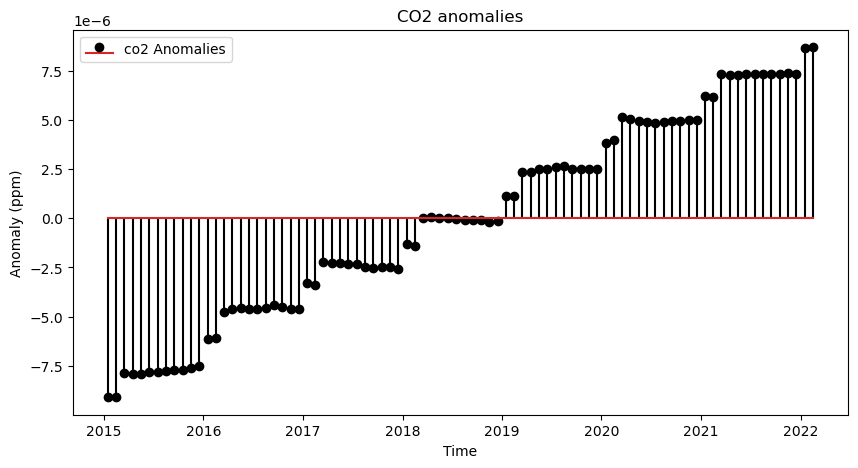

In [162]:
#3.2——4茎叶图
plt.figure(figsize=(10, 5))
plt.stem(anomalies.time, anomalies, 'ko', label='co2 Anomalies')
plt.title('CO2 anomalies')
plt.xlabel('Time')
plt.ylabel('Anomaly (ppm)')
plt.legend()
plt.show()

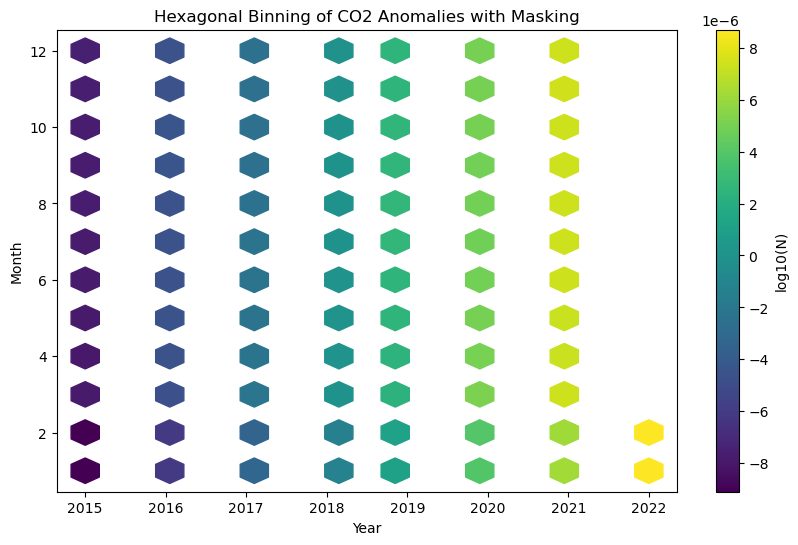

In [168]:
#3.2——5分箱图
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

# 打开netCDF文件
ds = xr.open_dataset("output_file.nc4", engine="netcdf4")

# 选择特定的经纬度范围，并计算空间平均值
xco2 = ds.XCO2.sel(lat=slice(-90, 90), lon=slice(-180, 179.4))
spatial_average = xco2.mean(dim=['lat', 'lon'])

# 按月计算平均值
monthly_avg = spatial_average.groupby('time.month').mean('time')

# 计算异常值
anomalies = spatial_average.groupby('time.month') - monthly_avg

# 转换为 pandas DataFrame
anomalies_df = anomalies.to_dataframe().reset_index()

# 绘制六边形分箱图，并掩膜掉数据点少于5的六边形
plt.figure(figsize=(10, 6))
hb = plt.hexbin(anomalies_df['time'].dt.year, anomalies_df['time'].dt.month, 
                    C=anomalies_df['XCO2'], gridsize=20,cmap='viridis')

plt.colorbar(label='log10(N)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Hexagonal Binning of CO2 Anomalies with Masking')
plt.show()